In [61]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

import yfinance as yf
import yahoo_fin.stock_info as si
# import pandas_datareader.data as web

from dateutil.relativedelta import relativedelta
from datetime import datetime

pd.set_option('display.max_rows', None, 'display.max_columns', None)

from sklearn.model_selection import train_test_split

## Model 1 
#### Target T0_5>0 --> Event 
#### Target T0_5<0 --> Non-event

In [ ]:
dfmdl1=pd.read_csv('data/model_1.csv')

In [145]:
dfmdl1.shape

(8259, 84)

In [146]:
dfmdl1.isna().sum()

Ticker                     0
beta_30avg                13
adjclose                  13
Fiscal Year                0
Fiscal Period              0
Revenue                    4
Net_income                 0
Shares                     0
Cash                       7
Assets                     0
CFO                        0
CAPX                    4450
Dividends               1844
FCF                        0
EPSsuprise_ind             0
Revenue_qoq              417
Revenue_yoy             1731
Net_Income_qoq           417
Net_Income_yoy          1731
Gross_margin             403
Gross_margin_qoq         810
Gross_margin_yoy        2075
Operating_margin           4
Operating_margin_qoq     423
Operating_margin_yoy    1739
Net_margin                 4
Net_margin_qoq           423
Net_margin_yoy          1739
Cash_yoy                1731
Assets_yoy              1731
Leverage                   0
CFO_qoq                  417
FCF_qoq                  417
Sector                     0
Industry      

### Step 1. Logic to fill missing values

In [ ]:
# Drop rows where the target is missing
dfmdl1=dfmdl1.dropna(subset=['T0_5'])

# Assume following attributes as 0 when missing
dfmdl1['CAPX'] = dfmdl1['CAPX'].fillna(0)
dfmdl1['Dividends'] = dfmdl1['Dividends'].fillna(0)
dfmdl1['Dividend_yields_new'] = dfmdl1['Dividend_yields_new'].fillna(0)
dfmdl1['Assets_yoy'] = dfmdl1['Assets_yoy'].fillna(0)
dfmdl1['Cash_yoy'] = dfmdl1['Cash_yoy'].fillna(0)

# Assume missing gross margin = net margin  (rationale: certain industry doesn't report gross margin)
dfmdl1['Gross_margin'] = dfmdl1['Gross_margin'].fillna(dfmdl1['Net_margin'])

# Assume missing QoQ change from average
dfmdl1["Revenue_qoq"]  = dfmdl1['Revenue_qoq'].fillna(dfmdl1.groupby('Ticker')['Revenue_qoq'].transform('mean'))
dfmdl1["Net_Income_qoq"]  = dfmdl1['Net_Income_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_Income_qoq'].transform('mean'))
dfmdl1["Gross_margin_qoq"]  = dfmdl1['Gross_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Gross_margin_qoq'].transform('mean'))
dfmdl1["Operating_margin_qoq"]  = dfmdl1['Operating_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Operating_margin_qoq'].transform('mean'))
dfmdl1["Net_margin_qoq"]  = dfmdl1['Net_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_margin_qoq'].transform('mean'))

# Assume missing YoY change is interpolated from QoQ 
def interpolation(df,var):
    df[var+'_yoy'].fillna((1+df[var+'_qoq'])**4-1, inplace=True)
    return df

for var in ['Revenue','Net_Income','Gross_margin','Operating_margin','Net_margin']:
    interpolation(dfmdl1,var)

# Assume missing sentiment score from ticker's average, it still missing then 0
dfmdl1["cs_last5"]  = dfmdl1['cs_last5'].fillna(dfmdl1.groupby('Ticker')['cs_last5'].transform('mean'))
dfmdl1['cs_last5'] = dfmdl1['cs_last5'].fillna(0)

In [ ]:
dfmdl1.isna().sum()

### Step 2. Define Target

In [148]:
dfmdl1['target'] = np.where(dfmdl1['T0_5']>0, 1, 0)

### Step 3. Data Exploration

In [149]:
dfmdl1.columns

Index(['Ticker', 'beta_30avg', 'adjclose', 'Fiscal Year', 'Fiscal Period',
       'Revenue', 'Net_income', 'Shares', 'Cash', 'Assets', 'CFO', 'CAPX',
       'Dividends', 'FCF', 'EPSsuprise_ind', 'Revenue_qoq', 'Revenue_yoy',
       'Net_Income_qoq', 'Net_Income_yoy', 'Gross_margin', 'Gross_margin_qoq',
       'Gross_margin_yoy', 'Operating_margin', 'Operating_margin_qoq',
       'Operating_margin_yoy', 'Net_margin', 'Net_margin_qoq',
       'Net_margin_yoy', 'Cash_yoy', 'Assets_yoy', 'Leverage', 'CFO_qoq',
       'FCF_qoq', 'Sector', 'Industry', 'Next_EarningDate', 'RSI', 'MFI',
       'adjclose_SMA_12', 'adjclose_SMA_30', 'adjclose_EWMA_12',
       'adjclose_EWMA_30', 'adjclose_UpperBand', 'adjclose_LowerBand',
       'SMA_12_SMA_30', 'EWMA_12_EWMA_30', 'UpperBand_LowerBand', '^GSPC',
       '^GSPC_pctchange_5', '^GSPC_pctchange_21', '^GSPC_pctchange_yoy',
       '^RUT', '^RUT_pctchange_5', '^RUT_pctchange_21', '^RUT_pctchange_yoy',
       '^VIX', '^VIX_pctchange_5', '^VIX_pctchange_2

In [79]:
# create quantile bins
def create_quantile_bin(df,var,binnumber):
    df['qbin_'+var] = pd.qcut(df[var], q=binnumber, precision=0).astype(str)
    df.loc[df[var].isna(), 'qbin_'+var] = 'missing'

In [80]:
create_quantile_bin(dfmdl1,'beta_30avg',10)
create_quantile_bin(dfmdl1,'cs_last5',10)
create_quantile_bin(dfmdl1,'Market_cap_mm',10)

In [64]:
dfmdl1.Sector.value_counts()

Industrials               1296
Technology                1270
Healthcare                1122
Consumer Cyclical          998
Consumer Defensive         687
Real Estate                485
Utilities                  482
Communication Services     407
Financial Services         405
Energy                     357
Basic Materials            332
Name: Sector, dtype: int64

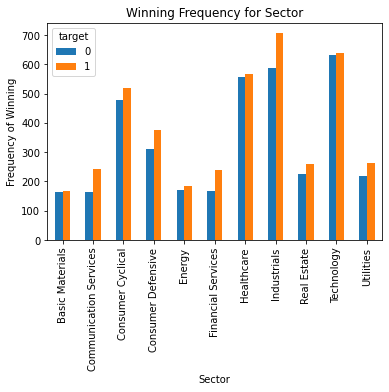

In [85]:
%matplotlib inline
pd.crosstab(dfmdl1.Sector,dfmdl1.target).plot(kind='bar')
plt.title('Winning Frequency for Sector')
plt.xlabel('Sector')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_sector')

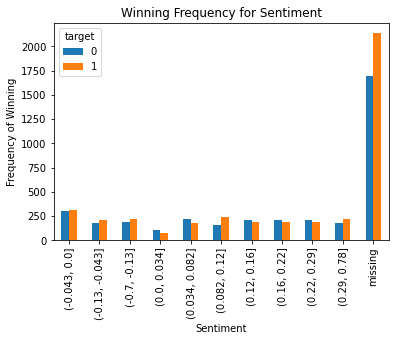

In [81]:
%matplotlib inline
pd.crosstab(dfmdl1.qbin_cs_last5,dfmdl1.target).plot(kind='bar')
plt.title('Winning Frequency for Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_sentiment')

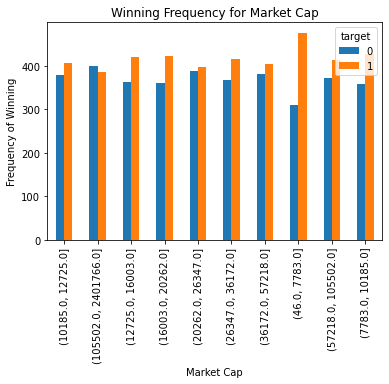

In [83]:
%matplotlib inline
pd.crosstab(dfmdl1.qbin_Market_cap_mm,dfmdl1.target).plot(kind='bar')
plt.title('Winning Frequency for Market Cap')
plt.xlabel('Market Cap')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_marketcap')

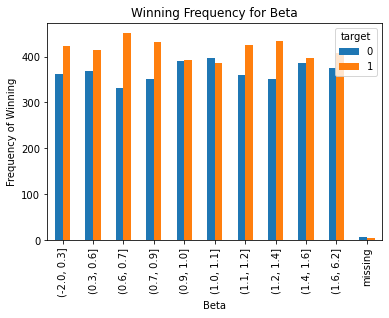

In [84]:
%matplotlib inline
pd.crosstab(dfmdl1.qbin_beta_30avg,dfmdl1.target).plot(kind='bar')
plt.title('Winning Frequency for Beta')
plt.xlabel('Beta')
plt.ylabel('Frequency of Winning')
plt.savefig('winning_fre_beta')

In [119]:
dfmdl1_clean=dfmdl1.drop(columns=['Ticker', 'Fiscal Year', 'Fiscal Period', 'Shares', 'Next_EarningDate','Industry','Gross_margin_yoy'
                                 ,'qbin_beta_30avg','qbin_cs_last5', 'qbin_Market_cap_mm','EPSsuprise_ind'])

In [120]:
# encode the categorical column
char_var_list=['Sector']
               #, 'qbin_beta_30avg','qbin_cs_last5', 'qbin_Market_cap_mm']
for var in char_var_list:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(dfmdl1_clean[var], prefix=var)
    data1=dfmdl1_clean.join(cat_list)
    dfmdl1_clean=data1

data_vars=dfmdl1_clean.columns.values.tolist()
to_keep=[i for i in data_vars if i not in char_var_list]

dfmdl1_clean=dfmdl1_clean[to_keep]
dfmdl1_clean.columns.values

array(['beta_30avg', 'adjclose', 'Revenue', 'Net_income', 'Cash',
       'Assets', 'CFO', 'CAPX', 'Dividends', 'FCF', 'Revenue_qoq',
       'Revenue_yoy', 'Net_Income_qoq', 'Net_Income_yoy', 'Gross_margin',
       'Gross_margin_qoq', 'Gross_margin_yoy', 'Operating_margin',
       'Operating_margin_qoq', 'Operating_margin_yoy', 'Net_margin',
       'Net_margin_qoq', 'Net_margin_yoy', 'Cash_yoy', 'Assets_yoy',
       'Leverage', 'CFO_qoq', 'FCF_qoq', 'RSI', 'MFI', 'adjclose_SMA_12',
       'adjclose_SMA_30', 'adjclose_EWMA_12', 'adjclose_EWMA_30',
       'adjclose_UpperBand', 'adjclose_LowerBand', 'SMA_12_SMA_30',
       'EWMA_12_EWMA_30', 'UpperBand_LowerBand', '^GSPC',
       '^GSPC_pctchange_5', '^GSPC_pctchange_21', '^GSPC_pctchange_yoy',
       '^RUT', '^RUT_pctchange_5', '^RUT_pctchange_21',
       '^RUT_pctchange_yoy', '^VIX', '^VIX_pctchange_5',
       '^VIX_pctchange_21', '^VIX_pctchange_yoy', 'GC=F',
       'GC=F_pctchange_5', 'GC=F_pctchange_21', 'GC=F_pctchange_yoy',
       '

In [121]:
X=dfmdl1_clean.drop(columns='target')
y=dfmdl1_clean[['target']]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    train_size=0.7)

In [123]:
X_train.dtypes

beta_30avg                       float64
adjclose                         float64
Revenue                          float64
Net_income                         int64
Cash                             float64
Assets                             int64
CFO                              float64
CAPX                             float64
Dividends                        float64
FCF                                int64
Revenue_qoq                      float64
Revenue_yoy                      float64
Net_Income_qoq                   float64
Net_Income_yoy                   float64
Gross_margin                     float64
Gross_margin_qoq                 float64
Gross_margin_yoy                 float64
Operating_margin                 float64
Operating_margin_qoq             float64
Operating_margin_yoy             float64
Net_margin                       float64
Net_margin_qoq                   float64
Net_margin_yoy                   float64
Cash_yoy                         float64
Assets_yoy      

In [124]:
data_final_vars=X.columns.values.tolist()

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

/Users/feiyiyang/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [101]:
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

# Predict outcomes for test data set
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

ValueError: could not convert string to float: 'Software—Application'